* 284,807건의 데이터중 492건이 Fraud임. 전체의 0.172%
* 불균형한 데이터 셋임
    * 언더 샘플링은 사기 데이터(적은 레이블)만큼 정상데이터(많은 레이블)를 감소시켜서 샘플링
    * 오버 샘플링은 사기 데이터(적은 레이블)를 정상데이터(많은 레이블)만큼 늘리는 샘플링 

# 데이터 셋 및 필요 모듈 로딩

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

from IPython.display import display_html
def display_side_by_side(*args):
    """여러 데이터프레임 비교가 쉽게 옆쪽으로 표시한다"""
    html_str=''
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'), raw=True)

card_df = pd.read_csv("C:/Users/wkdgu/권철민 머신러닝/실습파일/5장/creditcard.csv")
card_df.head(3)

# 원래 많은 피쳐가 있었는데 PCA로 피쳐를 줄임
# 피쳐가 V1~V28로 표시가 되어있는데 민감한 개인정보라서 형태를 변환
# amount는 사용 금액, Class는 0은 정상, 1은 사기 거래

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


# 기본적인 FE만 실행

## get_preprocessed_df() 함수 생성
* DataFrame을 복사하고 Time 컬럼만 삭제한 뒤 복사된 DataFrame 반환하는 함수 생성

In [2]:
# DataFrame을 복사하고 Time 컬럼만 삭제한 뒤 복사된 DataFrame 반환하는 함수 생성

def get_preprocessed_df(df):
    df_copy = df.copy()
    df_copy.drop('Time', axis = 1, inplace = True)
    return df_copy

## get_train_test_dataset() 함수 생성
* get_preporcessed_df을 포함해서 train, test로 데이터 셋을 분리하는 함수 생성
* 인자로 DataFrame을 받습니다.

In [3]:
# get_preporcessed_df을 포함해서 train, test로 데이터 셋을 분리하는 함수 생성

from sklearn.model_selection import train_test_split

def get_train_test_dataset(df):
    # 위에서 Time컬럼을 삭제하고 복사본을 반환하는 함수를 호출
    df_copy = get_preprocessed_df(df)
    
    # DataFrame의 맨 마지막 컬럼이 레이블, 나머지는 피쳐들
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    
    # train_test_split( )으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
    X_train, X_test, y_train, y_test = \
    train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    
    
    # 학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

In [4]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [5]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0])
print("")
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0])

학습 데이터 레이블 값 비율
0    0.998275
1    0.001725
Name: Class, dtype: float64

테스트 데이터 레이블 값 비율
0    0.998268
1    0.001732
Name: Class, dtype: float64


## 분류 평가 지표 함수 생성

In [6]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 분류 평가 지표 함수 생성

def get_clf_eval(y_test, pred, pred_proba):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)

    print('오차 행렬')
    print(confusion)
    
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

## get_model_train_eval() 함수 생성
* 인자로 사이킷런의 Estimator객체와, 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행하는 함수 생성

In [7]:
# 인자로 사이킷런의 Estimator객체와, 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행하는 함수 생성

def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

## LogisticRegression 실행

In [8]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()

lr_clf.fit(X_train, y_train)

lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85280    15]
 [   59    89]]
정확도: 0.9991, 정밀도: 0.8558, 재현율: 0.6014,    F1: 0.7063, AUC:0.9629


## LGBMClassifier 실행

In [9]:
# LightGBM 2.1.0 이상 버전에서 boost_from_average가 True가 디폴트가 됨. boost_from_average가 True일 경우 레이블 값이 극도로 불균형
# 분포를 이루는 경우 재현율 및 ROC-AUC성능이 매우 저하됨. 레이블 값이 극도로 불균형일 경우 boost_from_average를 False로 설정하는 것이 유리

# target값이 highly unbalanced아닌 일반적인 경우 boost_from_average가 True인게 더 유리

from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568,    F1: 0.8453, AUC:0.9790


# 스케일링 FE도 추가하고 실행

## Amount 칼럼의 분포를 확인합니다.

In [10]:
# 소액결제는 상당히 많지만 고액결제는 매우 적은 것을 확인할 수 있음
display_side_by_side(pd.DataFrame(card_df['Amount'].value_counts().sort_index().head(20)),
                     pd.DataFrame(card_df['Amount'].value_counts().sort_index().iloc[21:40]),
                     pd.DataFrame(card_df['Amount'].value_counts().sort_index().iloc[100:120]),
                     pd.DataFrame(card_df['Amount'].value_counts().sort_index().iloc[200:220]),
                     pd.DataFrame(card_df['Amount'].value_counts().sort_index().tail(20)))

,Amount
0.00,1825
0.01,718
0.02,85
0.03,3
0.04,11
0.05,44
0.06,3
0.07,11
0.08,10
0.09,2


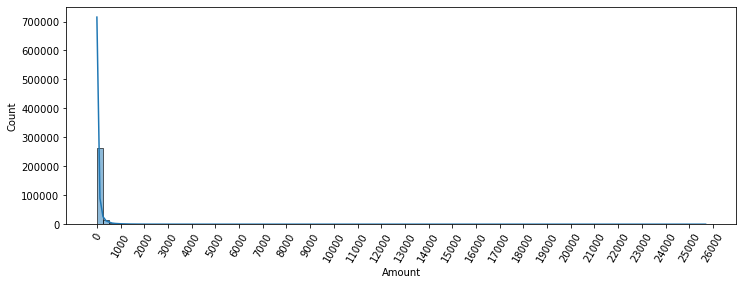

In [11]:
# range(start, stop, step)
# range(0, 20, 2)
# 0, 2, 4, 6, 8, 10, 12, 14, 16, 18

# 굉장히 skewed to the right(positively skewed)된 것을 확인할 수 있음
# skewed된 분포를 StandardScaler와 로그변환을 통해 분포를 변화시켜야됨
import seaborn as sns

plt.figure(figsize = (12,4))
plt.xticks(range(0, 30000, 1000), rotation = 60)
sns.histplot(card_df['Amount'], bins=100, kde =True)
plt.show()

## get_preprocessed_df 함수에 Amount를 Z변환하는 스케일링 추가 
* Amount 칼럼이 표준 정규분포를 따르게 만듭니다.
* DataFrame을 복사하고 Time과 기존의 Amount 컬럼을 삭제한 뒤 복사된 DataFrame 반환하는 함수 생성

In [12]:
from sklearn.preprocessing import StandardScaler

# ndarray를 reshape(-1, 1)하면 컬럼은 1개, 행은 데이터에 맞춰줍니다. 즉 2차원 형태가 됩니다.
# StandardScaler는 데이터를 평균이 0, 분산이 1인 표준 정규분포 형태로 변환
# StandardScaler는 2차원 ndarray가 필요함

# DataFrame.insert(컬럼 위치, '컬럼명', 컬럼) : 데이터프레임에 컬럼을 삽입합니다.

def get_preprocessed_df(df):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    
    # DataFrame의 0번째 컬럼에 컬럼명은 'Amount_Scaled'로 해서 amount_n을 집어넣음
    df_copy.insert(0, 'Amount_Scaled', amount_n)    
    
    # 기존 Time, Amount 칼럼 삭제
    df_copy.drop(['Time', 'Amount'], axis = 1, inplace = True)
    return df_copy

In [13]:
# copy를 사용해서 원본 데이터인 card_df는 변하지 않음 
card_df_test = get_preprocessed_df(card_df)
display(card_df_test)
display(card_df)

,Amount_Scaled,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,0.244964,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.342475,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,1.160686,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,0.140534,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,-0.073403,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-0.350151,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0
284803,-0.254117,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0
284804,-0.081839,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0
284805,-0.313249,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,0


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


## StandardScaler 변환 후 로지스틱 회귀 및 LightGBM 학습/예측/평가

In [14]:
# get_train_test_dataset은 인자로 DataFrame을 받고 train, test로 데이터 셋을 분리하는 함수입니다.
# get_train_test_dataset함수는 get_preporcessed_df을 포함하고 있습니다.
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)


# 인자로 사이킷런의 Estimator객체와, 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행하는 함수 생성
print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

print("")

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs = -1, boost_from_average = False )
get_model_train_eval(lgbm_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081,    F1: 0.7143, AUC:0.9702

### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   37   111]]
정확도: 0.9995, 정밀도: 0.9569, 재현율: 0.7500,    F1: 0.8409, AUC:0.9779


**표준정규화를 하지 않았을 때와 비교해서 성능지표가 좋아지지 않았습니다.**

## get_preprocessed_df 함수에 Amount를 로그변환하는 스케일링 추가

In [15]:
# 0을 로그변환하면 -inf(무한대)가 나옵니다.
# 1e-1000같은 굉장히 작은 수는 수치해석상 0과 동일시됩니다.
# 1을 로그변환하면 0이 나옵니다.
# 매우 작은수가 로그변환되서 -inf가 되는 것을 막기 위해 log1p를 사용합니다.
# log1p(x)는 x -> log(x+1)로 바꿔줍니다. 

print(1e-1000 == 0.0)
print(np.log(1e-1000))

# 밑의 둘은 동일합니다.
print(np.log(1e-1000 + 1))
print(np.log1p(1e-1000))

True
-inf
0.0
0.0


np.expm1(x)은 x -> $e^x-1$로 변환해줍니다.

In [16]:
print(np.log1p(100), np.expm1(np.log1p(100)))

4.61512051684126 100.00000000000003


In [17]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis = 1, inplace = True)
    return df_copy

In [18]:
card_df_test = get_preprocessed_df(card_df)
card_df_test

,Amount_Scaled,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,5.014760,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,1.305626,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,5.939276,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,4.824306,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,4.262539,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,0.570980,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0
284803,3.249987,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0
284804,4.232366,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0
284805,2.397895,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,0


## 로그 변환 후 로지스틱 회귀 및 LightGBM 학습/예측/평가

In [19]:
# get_train_test_dataset은 인자로 DataFrame을 받고 train, test로 데이터 셋을 분리하는 함수입니다.
# get_train_test_dataset함수는 get_preporcessed_df을 포함하고 있습니다.

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)


### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014,    F1: 0.7149, AUC:0.9727
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635,    F1: 0.8496, AUC:0.9796


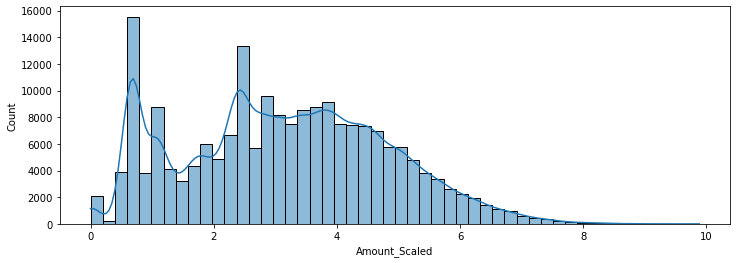

In [20]:
# 로그변환한 Amount_Scaled 칼럼을 시각화합니다.
plt.figure(figsize = (12,4))
sns.histplot(X_train['Amount_Scaled'], bins = 50, kde = True)
plt.show()

# 이상치 제거 FE도 추가하고 실행

## 결정 레이블인 class값과 가장 상관도가 높은 피처 추출
* 각 피쳐들의 상관관계를 시각화

<AxesSubplot:>

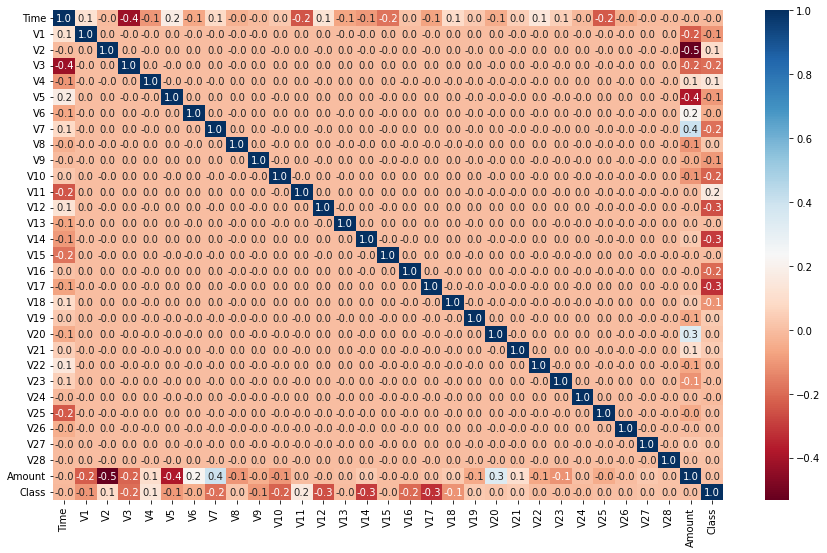

In [21]:
# -1과 1에 가까우면 상관도가 높습니다.
plt.figure(figsize=(15,9))

# corr은 데이터프레임입니다.
corr = card_df.corr()    

# annot = True는 상관관계를 표시, fmt = '0.1f'는 상관관계를 소숫점 첫번째 짜리까지 표시하라는 뜻입니다.
sns.heatmap(corr, annot =True, fmt='0.1f', cmap = 'RdBu') 

In [22]:
card_df[card_df['Class'] == 1]['V14']

541      -4.289254
623      -1.692029
4920     -1.470102
6108     -6.771097
6329     -6.079337
            ...   
279863   -6.665177
280143   -5.210141
280149   -4.057162
281144   -6.416628
281674   -1.948883
Name: V14, Length: 492, dtype: float64

## get_outlier 함수 생성
* 해당 컬럼의 이상치 인덱스를 반환합니다.

In [23]:
def get_outlier(df=None, column = None, weight = 1.5):
    # 함수에 들어오는 해당 컬럼의 사기데이터만 fraud에 삽입합니다.
    fraud = df[df['Class']==1][column]
    
    # np.percentile은 데이터의 사분위수를 반환합니다.
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr*weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 - iqr_weight
    
    # 이상치 DataFrame의 index 반환
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    
    return outlier_index

In [24]:
outlier_index = get_outlier(df=card_df, column='V14', weight = 1.5)
print(outlier_index) # 이상치 데이터의 인덱스입니다.
print(outlier_index.shape) # 433개의 데이터가 이상치입니다.

Int64Index([   541,    623,   4920,   6108,   6329,   6331,   6334,   6336,
              6338,   6427,
            ...
            274382, 274475, 275992, 276071, 276864, 279863, 280143, 280149,
            281144, 281674],
           dtype='int64', length=433)
(433,)


 ##  get_preprocessed_df 함수에 로그변환 및 이상치 제거 기능 추가

**로그 변환 후 V14 피처의 이상치 데이터를 삭제한 뒤 모델들을 재 학습/예측/평가**

In [25]:
# get_processed_df( )를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경. 

def get_preprocessed_df(df):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace = True)
    
    # 이상치 데이터 삭제하는 로직 추가
    oulier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis = 0, inplace = True)
    
    return df_copy

## FE 후 로지스틱 회귀 및 LightGBM 학습/예측/평가

In [26]:
# get_train_test_dataset은 인자로 DataFrame을 받고 train, test로 데이터 셋을 분리하는 함수입니다.
# get_train_test_dataset함수는 get_preporcessed_df을 포함하고 있습니다.

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85293     2]
 [    1    17]]
정확도: 1.0000, 정밀도: 0.8947, 재현율: 0.9444,    F1: 0.9189, AUC:1.0000
### LightGBM 예측 성능 ###
오차 행렬
[[85294     1]
 [    1    17]]
정확도: 1.0000, 정밀도: 0.9444, 재현율: 0.9444,    F1: 0.9444, AUC:1.0000


# SMOTE 오버 샘플링 적용 후 실행

In [27]:
import imblearn
print(imblearn.__version__)

0.9.1


## train data에 오버샘플링 적용

In [35]:
# 학습만 오버샘플링을 적용해야됨. 
# 테스트 데이터 셋에는 오버샘플링을 적용하면 안됨
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (199061, 29) (199061,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 0    199020
1    199020
Name: Class, dtype: int64


In [41]:
# y_train의 불균형한 클래스 분포가 동일하게 바뀜

print(y_train.value_counts())
print("")
print( y_train_over.value_counts())

0    199020
1        41
Name: Class, dtype: int64

0    199020
1    199020
Name: Class, dtype: int64


## 로지스틱 회귀로 학습/예측/평가 

In [50]:
lr_clf = LogisticRegression()
# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, ftr_train = X_train_over, ftr_test = X_test, tgt_train = y_train_over, tgt_test = y_test)

오차 행렬
[[85292     3]
 [    1    17]]
정확도: 1.0000, 정밀도: 0.8500, 재현율: 0.9444,    F1: 0.8947, AUC:1.0000


##  Precision-Recall 곡선 시각화 

In [59]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출.
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle = '--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label = 'recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()

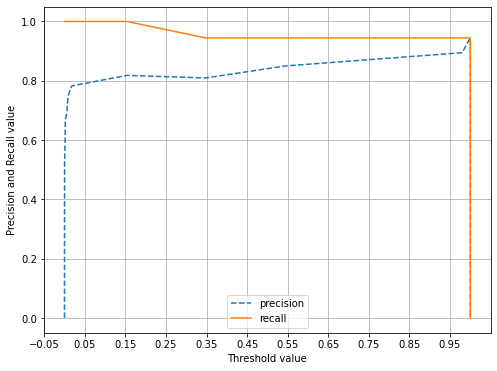

In [60]:
precision_recall_curve_plot( y_test, lr_clf.predict_proba(X_test)[:, 1] )

In [61]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test,
                  tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[85294     1]
 [    0    18]]
정확도: 1.0000, 정밀도: 0.9474, 재현율: 1.0000,    F1: 0.9730, AUC:1.0000
